<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">2. Color spaces and image processing</p>

### En esta práctica, trabajaremos con los espacios de color RGB y HSV, veremos la diferencia de cada uno de ellos e implementaremos un detector de bordes que probaremos con imágenes en ambos espacios.

### Primero, buscaremos segmentar una imagen a partir de su espacio de  color. Para eso utilizaremos dos funciones de opencv principalmente: "bitwise_and" e "inRange".

In [52]:
import cv2
import numpy as np
import imageio
import glob

import matplotlib.pyplot as plt
from matplotlib import colors

from mpl_toolkits.mplot3d import Axes3D  # noqa
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

### convierte las imágenes de tu dataset al espacio RGB (ojo que openCV trabaja por defecto en BGR)

In [53]:
def load_images(filenames):
    return [imageio.imread(filename) for filename in filenames]

In [54]:
filenames = list(sorted(glob.glob("patterns/*.jpg")))
imgs = load_images(filenames)

/var/folders/jl/pgfmllpj0kj1p2cj6jnb9tph0000gn/T/ipykernel_12348/3789968186.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return [imageio.imread(filename) for filename in filenames]


In [55]:
path = "patterns/img"

patterns = {}
for i in range(7):
    img_path = path + str(i) + ".jpg"
    friend = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    patterns[img_path] = friend

In [56]:
def hsv_to_range(hsv):
    # blue = [219*179//360, 0.93*255, 0.41*255]
    hsv = [hsv[0]*179//360, hsv[1]/100*255, hsv[2]/100*255]
    return np.array([hsv[0] - 10, hsv[1] - 50, hsv[2] - 50]), np.array([hsv[0] + 10, hsv[1] + 50, hsv[2] + 50])



In [57]:
blue = [219, 93, 41]
yellow = [46, 100, 68]
green = [137, 99, 31]
red = [357, 96, 54]
black = [192, 36, 5]
purple = [267, 55, 46]

## Get the ranges

In [58]:
blue_lower_hsv, blue_upper_hsv = hsv_to_range(blue)
yellow_lower_hsv, yellow_upper_hsv = hsv_to_range(yellow)
green_lower_hsv, green_upper_hsv = hsv_to_range(green)
red_lower_hsv, red_upper_hsv = hsv_to_range(red)
black_lower_hsv, black_upper_hsv = hsv_to_range(black)
purple_lower_hsv, purple_upper_hsv = hsv_to_range(purple)

In [84]:
def aislar_color(friend):
    hsv_image = cv2.cvtColor(friend, cv2.COLOR_RGB2HSV)
    blue_mask = cv2.inRange(hsv_image, blue_lower_hsv, blue_upper_hsv)
    yellow_mask = cv2.inRange(hsv_image, yellow_lower_hsv, yellow_upper_hsv)
    green_mask = cv2.inRange(hsv_image, green_lower_hsv, green_upper_hsv)
    red_mask = cv2.inRange(hsv_image, red_lower_hsv, red_upper_hsv)
    black_mask = cv2.inRange(hsv_image, black_lower_hsv, black_upper_hsv)
    purple_mask = cv2.inRange(hsv_image, purple_lower_hsv, purple_upper_hsv)
    
    blue_result = cv2.bitwise_and(friend, friend, mask=blue_mask)
    yellow_result = cv2.bitwise_and(friend, friend, mask=yellow_mask)
    green_result = cv2.bitwise_and(friend, friend, mask=green_mask)
    red_result = cv2.bitwise_and(friend, friend, mask=red_mask)
    black_result = cv2.bitwise_and(friend, friend, mask=black_mask)
    purple_result = cv2.bitwise_and(friend, friend, mask=purple_mask)

    result = cv2.bitwise_or(blue_result, yellow_result)
    result = cv2.bitwise_or(result, green_result)
    result = cv2.bitwise_or(result, red_result)
    result = cv2.bitwise_or(result, black_result)
    result = cv2.bitwise_or(result, purple_result)

    return result
    # print(img_path)

    # plt.imshow(result)
    # plt.show()

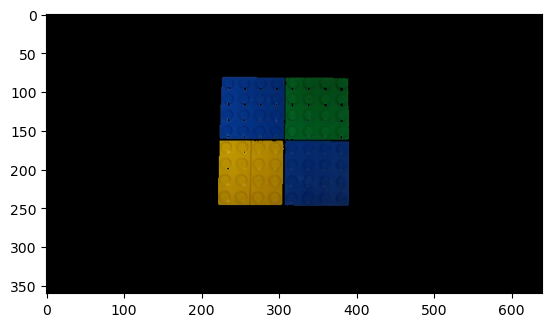

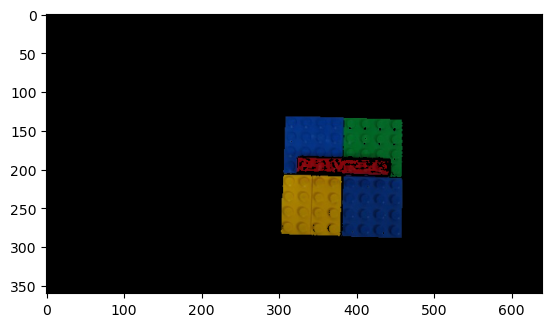

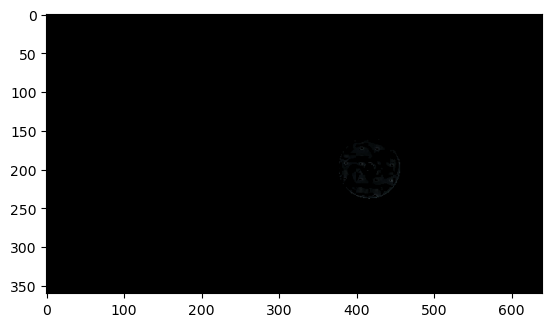

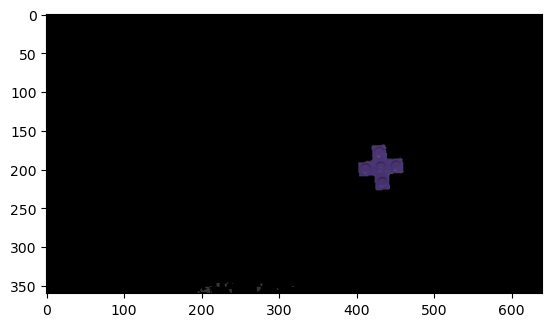

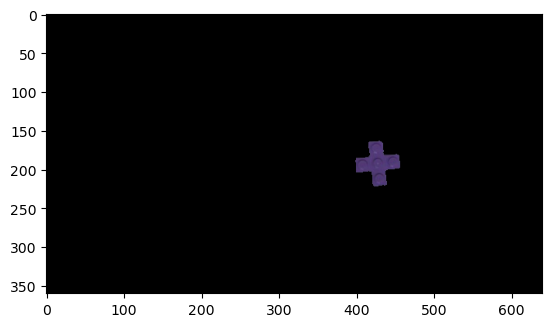

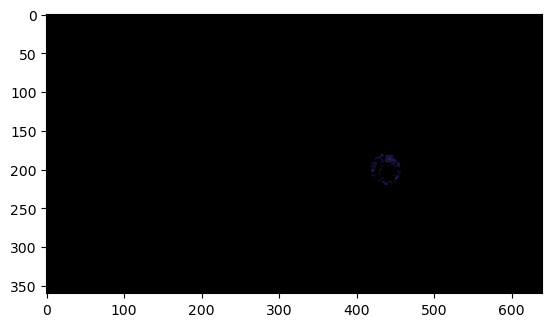

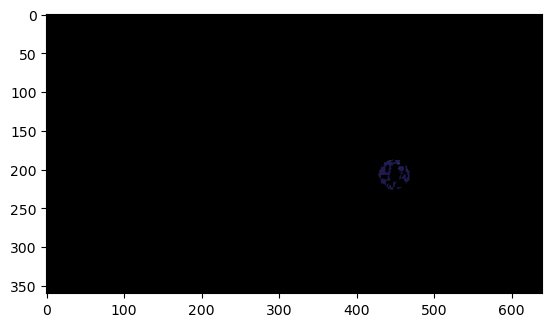

In [87]:
for img_path, friend in patterns.items():
    result = aislar_color(friend)
    plt.imshow(result)
    plt.show()

### Generaliza tu implementación y aplícala a todas las imágenes del dataset. Pega tus resultados en tu informe.

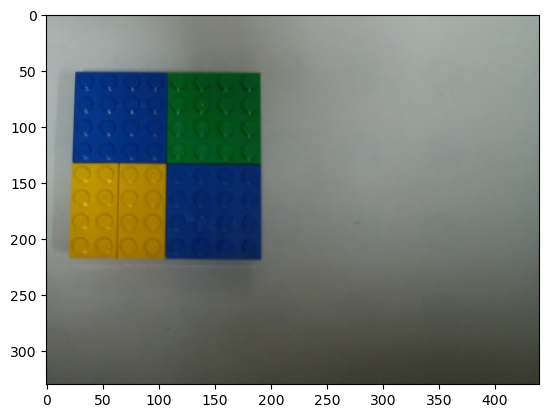

In [64]:
prueba1 = patterns["patterns/img0.jpg"][30:, 200:, :]
plt.imshow(prueba1)

In [92]:
shapes_path = "main_shapes/img"

main_shapes = {}
for i in range(4):
    img_path = shapes_path + str(i) + ".jpg"
    friend = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    main_shapes[img_path] = friend


In [115]:
import cv2
import numpy as np

def sift_match(image, patterns):
    sift = cv2.SIFT_create()

    # Detectar keypoints y calcular descriptores de la imagen
    kp_image, des_image = sift.detectAndCompute(image, None)

    best_match = -1
    best_match_score = 0

    if des_image is None:
        return best_match, best_match_score
    # Iterate over patterns and find the best match
    for pattern_number, pattern in patterns.items():
        # Detectar keypoints y calcular descriptores del patron
        kp_pattern, des_pattern = sift.detectAndCompute(pattern, None)

        bf = cv2.BFMatcher()
        
        # Matcheo de descriptores entre la imagen y el patron
        matches = bf.knnMatch(des_pattern, des_image, k=2)

        # Aplicar el test de ratio
        good_matches = []
        for match in matches:
            if len(match) == 2:
                m, n = match
                if m.distance < 0.75 * n.distance:
                    good_matches.append(m)
            elif len(match) == 1:
                m = match[0]
                good_matches.append(m)

        # Calcular el score del match
        match_score = len(good_matches)

        # Actualizar el mejor match
        if match_score > best_match_score:
            best_match = pattern_number
            best_match_score = match_score

    return best_match, best_match_score


result = sift_match(aislar_color(patterns["patterns/img0.jpg"]), main_shapes)
print(result)


[['main_shapes/img0.jpg', 18], ['main_shapes/img1.jpg', 9], ['main_shapes/img2.jpg', 0], ['main_shapes/img3.jpg', 1]]
('main_shapes/img0.jpg', 18)


In [118]:
# Orden de las figuras para desbloquear
PATRON = [0, 1, 3, 0]

In [119]:
def detectar_patron(imagen, posicion):
    '''
    Detecta si la imagen del input se corresponde con la figura de referencia en la posicion indicada
    return: bool

    '''
    return sift_match(aislar_color(imagen), main_shapes)[0].split(".")[0][-1] == str(PATRON[posicion])

In [122]:
detectar_patron(patterns["patterns/img0.jpg"][50:300,100:500], 3)

[['main_shapes/img0.jpg', 29], ['main_shapes/img1.jpg', 17], ['main_shapes/img2.jpg', 0], ['main_shapes/img3.jpg', 0]]


True

(0.6081081081081082, 0.7254901960784313, 255)
(0.6081081081081082, 0.7254901960784313, 255)
(0.6081081081081082, 0.7254901960784313, 255)
(0.6081081081081082, 0.7254901960784313, 255)
(0.6081081081081082, 0.7254901960784313, 255)
(0.6081081081081082, 0.7254901960784313, 255)


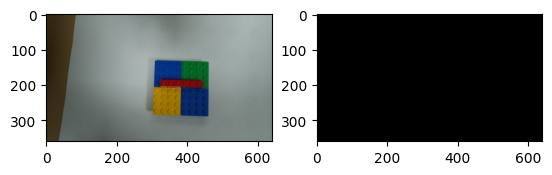

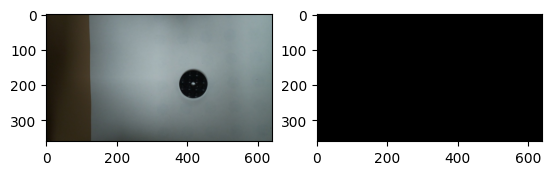

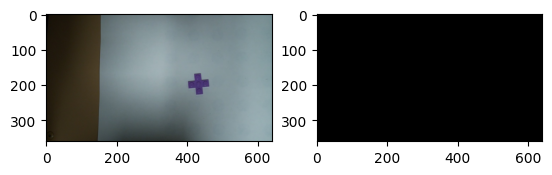

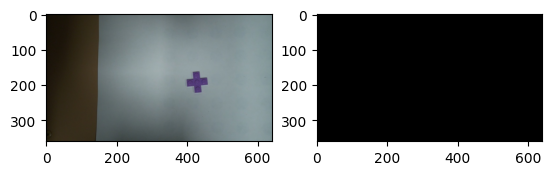

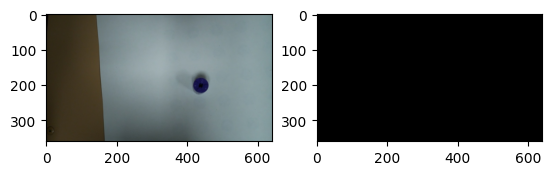

In [24]:
import colorsys

# No funciona aun el range de colores




def segment_color(image):
    """Attempts to segment the clown fish out of the provided image."""
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    light_blue = colorsys.rgb_to_hsv(70,  135, 255)
    dark_blue = colorsys.rgb_to_hsv(0,  30, 100)
    mask = cv2.inRange(hsv_image, light_blue, dark_blue)
    # light_white = (0, 0, 200)
    # dark_white = (145, 60, 255)
    # mask_white = cv2.inRange(hsv_image, light_white, dark_white)
    # final_mask = mask + mask_white
    final_mask = mask
    result = cv2.bitwise_and(image, image, mask=final_mask)
    result = cv2.GaussianBlur(result, (7, 7), 0)
    return result


results = [segment_color(friend) for friend in patterns]

for i in range(1, 6):
    plt.subplot(1, 2, 1)
    plt.imshow(patterns[i])
    plt.subplot(1, 2, 2)
    plt.imshow(results[i])
    plt.show()

## Parte 2: Image processing

### Implementa una función "convolution" con dos entradas: imagen y el kernel. Asume un Kernel 3x3 y 
### aplica padding para que la convolción pueda tener lugar en los pixeles de los extremos

In [19]:
def convolution(image, kernel):
    image = np.array(image)
    #image=image[:,:,0]
    print(image.shape)
    output = np.zeros_like(image)
    image_padded = np.pad(image, pad_width=1, mode='constant')
    if 1: #for i in range(image.shape[2]):
        for x in range(image.shape[1]):
            for y in range(image.shape[0]):
                output[y, x]=(kernel * image_padded[y: y+3, x: x+3]).sum()
    return output

### Ahora implementaremos un méotodo de edge detection llamado Sobel. Éste se basa en un filtro derivativo y usaremos el filtro 

filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

### Recuerda por la teoría, que el método Sobel devuelve dos matrices, una de la convolución de la imagen de entrada con el filtro original y otra que es el resultado de aplicar el filtro original traspuesto.

In [41]:
from mpl_toolkits.mplot3d import Axes3D
def sobel_edge_detection(image, filter):
    new_image_x = convolution(image, filter) #, verbose)
    new_image_y = convolution(image, np.flip(filter.T, axis=0))
 
    gradient_magnitude = np.sqrt(np.square(new_image_x) + np.square(new_image_y))
    gradient_magnitude *= 255.0 / gradient_magnitude.max()
    
    return gradient_magnitude
 

### Aplica tu edge detector a la imagen 0 del dataset

(185, 272, 3)
(184, 275)


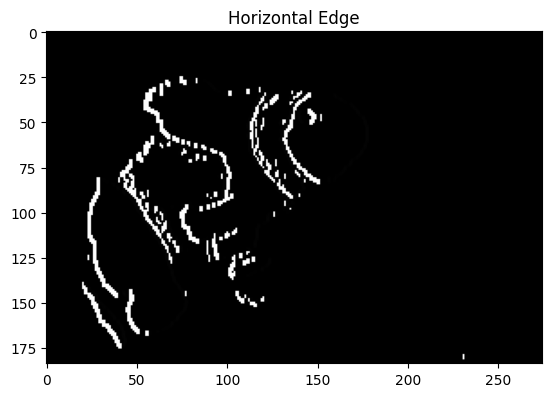

(184, 275)


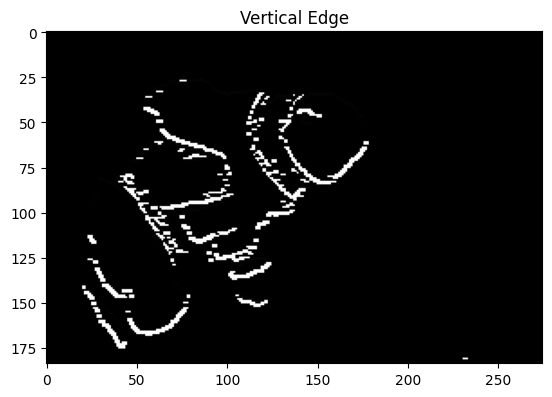

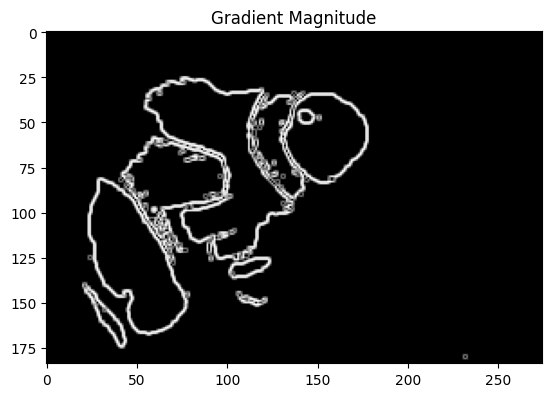

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)

In [43]:
from mpl_toolkits.mplot3d import Axes3D
filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
 
image = cv2.imread("./images/0.jpg")
print(image.shape)

#cv2.fastNlMeansDenoising(image,dst,self.templateWindowSize,self.searchWindowSize,self.h) 
plt.show()
#image = gaussian_blur(image, 9, verbose=True)
sobel_edge_detection(final_mask, filter, verbose=True)

### Implementa una función que calcule y aplique un filtro gaussiano que sirve para hacer la imagen más blurry. Recuerda la fórmula del filtro Gaussiano visto en teoría. La función debe devolver la imagen filtrada y el filtro calculado.

In [26]:
def gaussianBlur(img, sigma, filter_shape):
    if not filter_shape:
        aux = 2*int(4*sigma+0.5) + 1
        filter_shape = [aux,aux]
    
    size_y = filter_shape[0]//2
    size_x = filter_shape[1]//2
    gaussian_filter = np.zeros((size_y, size_x), np.float32)

    x, y = np.mgrid[-size_y:size_y+1, -size_x:size_x+1]
    normal = 1/(2*np.pi*sigma**2)
    gaussian_filter = np.exp(-((x**2+y**2)/(2*sigma**2)))*normal

    filtered = convolution(img, gaussian_filter)

    return gaussian_filter, filtered.astype(np.uint8)

In [33]:
import numpy as np


def togray(img: np.ndarray, format: str):
    '''
    Algorithm:
    >>> 0.2989 * R + 0.5870 * G + 0.1140 * B 

    - Returns a gray image
    '''
    if format.lower() == 'bgr':
        b, g, r = img[..., 0], img[..., 1], img[..., 2]
        return 0.2989 * r + 0.5870 * g + 0.1140 * b
    elif format.lower() == 'rgb':
        r, g, b = img[..., 0], img[..., 1], img[..., 2]
        return 0.2989 * r + 0.5870 * g + 0.1140 * b
    else:
        raise Exception('Unsupported value in parameter \'format\'')

In [25]:
import numpy as np


def convolution(image: np.ndarray, kernel: list | tuple) -> np.ndarray:
    '''
    It is a "valid" Convolution algorithm implementaion.

    ### Example

    >>> import numpy as np
    >>> from PIL import Image
    >>>
    >>> kernel = np.array(
    >>>     [[-1, 0, 1],
    >>>     [-2, 0, 2],
    >>>     [-1, 0, 1]], np.float32
    >>> )
    >>> img = np.array(Image.open('./lenna.png'))
    >>> res = convolution(img, Kx)
    '''

    if len(image.shape) == 3:
        m_i, n_i, c_i = image.shape

    # if the image is gray then we won't be having an extra channel so handling it
    elif len(image.shape) == 2:
        image = image[..., np.newaxis]
        m_i, n_i, c_i = image.shape
    else:
        raise Exception('Shape of image not supported')

    m_k, n_k = kernel.shape

    y_strides = m_i - m_k + 1  # possible number of strides in y direction
    x_strides = n_i - n_k + 1  # possible number of strides in x direction

    img = image.copy()
    output_shape = (m_i-m_k+1, n_i-n_k+1, c_i)
    output = np.zeros(output_shape, dtype=np.float32)

    count = 0  # taking count of the convolution operation being happening

    output_tmp = output.reshape(
        (output_shape[0]*output_shape[1], output_shape[2])
    )

    for i in range(y_strides):
        for j in range(x_strides):
            for c in range(c_i):
                sub_matrix = img[i:i+m_k, j:j+n_k, c]

                output_tmp[count, c] = np.sum(sub_matrix * kernel)

            count += 1

    output = output_tmp.reshape(output_shape)

    return output

### ¡Ojo! el método Sobel aplica un filtro gaussiano para hacer más blurry la imagen antes de aplicar los filtros derivativos. 
### Implementa una nueva función de edge detection con Sobel que tenga en cuenta esto. Ten en cuenta que la gaussiana se aplica sobre la imagen en escala de grises

In [28]:
import numpy as np
#from gaussian_blur import gaussianBlur
#from to_gray import togray
#from convolution import convolution


def sobelEdgeDetection(image: np.ndarray, sigma: int | float, image_format: str, filter_shape: int | None):
    img = togray(image, image_format)
    blurred = gaussianBlur(img, sigma, filter_shape=filter_shape)[1] / 255

    '''Gradient calculation / Sobel Filters'''
    Kx = np.array(
        [[-1, 0, 1],
         [-2, 0, 2],
         [-1, 0, 1]], np.float32
    )

    Ky = np.array(
        [[1, 2, 1],
         [0, 0, 0],
         [-1, -2, -1]], np.float32
    )

    Ix = convolution(blurred, Kx)
    Iy = convolution(blurred, Ky)

    G = np.hypot(Ix, Iy)

    G = G / G.max() * 255

    theta = np.arctan2(Iy, Ix)

    return np.squeeze(G), np.squeeze(theta)

In [29]:
import numpy as np


def non_max_suppression(img, theta):
    M, N = img.shape
    Z = np.zeros((M, N), dtype=np.int32)

    # converting radians to degree
    angle = theta * 180. / np.pi    # max -> 180, min -> -180
    angle[angle < 0] += 180         # max -> 180, min -> 0

    for i in range(1, M-1):
        for j in range(1, N-1):
            q = 255
            r = 255

            # angle 0
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                r = img[i, j-1]
                q = img[i, j+1]
            # angle 45
            elif (22.5 <= angle[i, j] < 67.5):
                r = img[i-1, j+1]
                q = img[i+1, j-1]
            # angle 90
            elif (67.5 <= angle[i, j] < 112.5):
                r = img[i-1, j]
                q = img[i+1, j]
            # angle 135
            elif (112.5 <= angle[i, j] < 157.5):
                r = img[i+1, j+1]
                q = img[i-1, j-1]

            if (img[i, j] >= q) and (img[i, j] >= r):
                Z[i, j] = img[i, j]
            else:
                Z[i, j] = 0
    return Z

### teniendo en cuenta los algoritmos ya implementados, Implementa un edge detection con el método canny, el cual es una secuencia de:
###     1. Edge detection con Sobel
###     2. El método NMS (non-maximum suppression) para homogeneizar el grosor de los cantos detectados
    
### Aplica tu método Canny a las imágenes de tu dataset

In [30]:
def cannyEdgeDetection(
    image: np.ndarray, sigma: int | float, filter_shape, image_format='rgb',
    lowthreshold: float | int = 0.05, highthreshold: float | int = 0.09
):
    G, theta = sobelEdgeDetection(image, sigma, image_format, filter_shape)
    img = non_max_suppression(G, theta)
    #img = threshold_hysteresis(img, lowthreshold, highthreshold)
    return img

### Aplica la función Canny a la imagen 0 del dataset con un kernel de tamaño 10x10 y sigma de 1.5.

### Juega con estos parámetros hasta encontrar la combinación que detecta los edges mejor. Aplícalo a todo el dataset y rellena el informe con estas pruebas

(184, 275, 3)


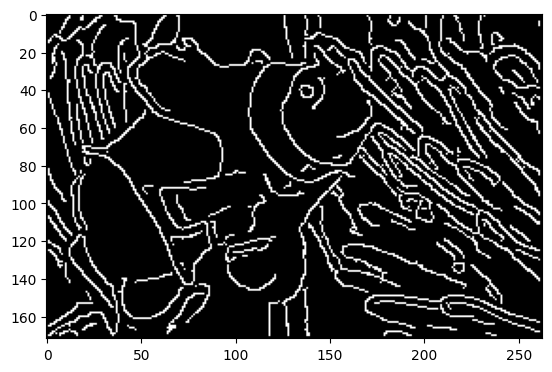

In [38]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
import matplotlib.pyplot as plt
filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
 
image = cv2.imread("./images/0.jpg")
print(image.shape)

#cv2.fastNlMeansDenoising(image,dst,self.templateWindowSize,self.searchWindowSize,self.h) 

#image = gaussian_blur(image, 9, verbose=True)
#cannyEdgeDetection(final_mask, filter)
res = cannyEdgeDetection(image, 1.5, (10, 10), 'rgb')
plt.imshow(res, cmap='gray')
plt.show()

### La librería de python skimage tiene ya implementadas las funciones de:
###     - gaussian
###     - sobel filter
    
### Investiga sobre ellas e implementa un filtro gaussiano y un edge detection con sobel usando los paquetes de skimage. Compara los resultados con los ya obtenidos.

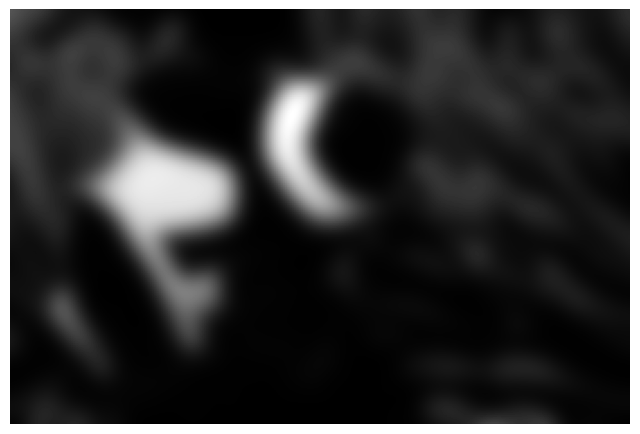

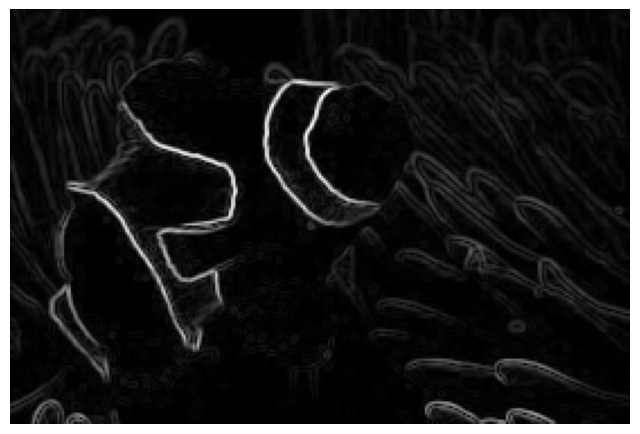

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.color as skic
import skimage.filters as skif
import skimage.data as skid
import skimage.util as sku


def show(img):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()
    plt.show()
    
    
image = cv2.imread("./images/0.jpg")
image=image[:,:,0]
show(skif.gaussian(image, 5.))

sobimg = skif.sobel(image)
show(sobimg)

### Implementa los operadores morfológicos: dilation and erosion. Utiliza para ello:

### - La imagen 0 del dataset
### - Un kernel de 3x3 con valores de 255 (blanco) como structuring element

### no olvides binarizar tu imagen antes de aplicar los operadores morfológicos


### Implementa primero la dilatación, muestra los resultados e inclúyelos en el informe

In [1]:
import numpy as np
import cv2
import json
from matplotlib import pyplot as plt

In [5]:
def read_this(image_file):
    image_src = cv2.imread(image_file, 0)
    return image_src

def convert_binary(image_src, thresh_val):
    color_1 = 255
    color_2 = 0
    initial_conv = np.where((image_src <= thresh_val), image_src, color_1)
    final_conv = np.where((initial_conv > thresh_val), initial_conv, color_2)
    return final_conv

def binarize_this(image_file, thresh_val=127):
    image_src = read_this(image_file=image_file)
    image_b = convert_binary(image_src=image_src, thresh_val=thresh_val)
    return image_b

In [6]:
def dilate_this(image_file, dilation_level=3, with_plot=False):
    # setting the dilation_level
    dilation_level = 3 if dilation_level < 3 else dilation_level
    
    # obtain the kernel by the shape of (dilation_level, dilation_level)
    structuring_kernel = np.full(shape=(dilation_level, dilation_level), fill_value=255)
    image_src = binarize_this(image_file=image_file)
    
    orig_shape = image_src.shape
    pad_width = dilation_level - 2
    
    # pad the image with pad_width
    image_pad = np.pad(array=image_src, pad_width=pad_width, mode='constant')
    pimg_shape = image_pad.shape
    h_reduce, w_reduce = (pimg_shape[0] - orig_shape[0]), (pimg_shape[1] - orig_shape[1])
    
    # obtain the submatrices according to the size of the kernel
    flat_submatrices = np.array([
        image_pad[i:(i + dilation_level), j:(j + dilation_level)]
        for i in range(pimg_shape[0] - h_reduce) for j in range(pimg_shape[1] - w_reduce)
    ])
    
    # replace the values either 255 or 0 by dilation condition
    image_dilate = np.array([255 if (i == structuring_kernel).any() else 0 for i in flat_submatrices])
    # obtain new matrix whose shape is equal to the original image size
    image_dilate = image_dilate.reshape(orig_shape)
    
    # plotting
    if with_plot:
        cmap_val = 'gray'
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))
        
        ax1.axis("off")
        ax1.title.set_text('Original')
        
        ax2.axis("off")
        ax2.title.set_text("Dilated - {}".format(dilation_level))
        
        ax1.imshow(image_src, cmap=cmap_val)
        ax2.imshow(image_dilate, cmap=cmap_val)
        plt.show()
        return True
    return image_dilate

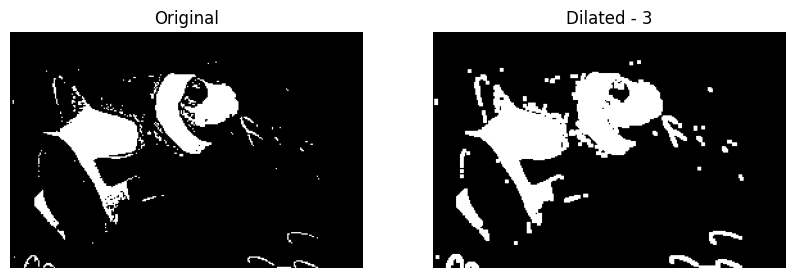

True

In [8]:
dilate_this(image_file="./images/0.jpg", dilation_level=3, with_plot=True)

### Implementa ahora la erosión, muestra los resultados e inclúyelos en el informe

In [13]:
def erode_lib(image_file, level=3, with_plot=True):
    level = 3 if level < 3 else level
    image_src = binarize_this(image_file=image_file)
    # library method
    image_eroded = cv2.erode(src=image_src, kernel=np.ones((level, level)), iterations=1)

    if with_plot:
        cmap_val = 'gray'
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

        ax1.axis("off")
        ax1.title.set_text('Original')

        ax2.axis("off")
        ax2.title.set_text("Eroded - {}".format(level))

        ax1.imshow(image_src, cmap=cmap_val)
        ax2.imshow(image_eroded, cmap=cmap_val)
        plt.show()
        return True
    return image_eroded

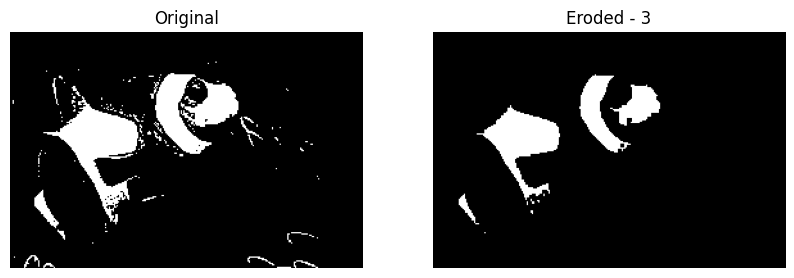

True

In [14]:
erode_lib(image_file="./images/0.jpg", level=3, with_plot=True)

(184, 275, 3)


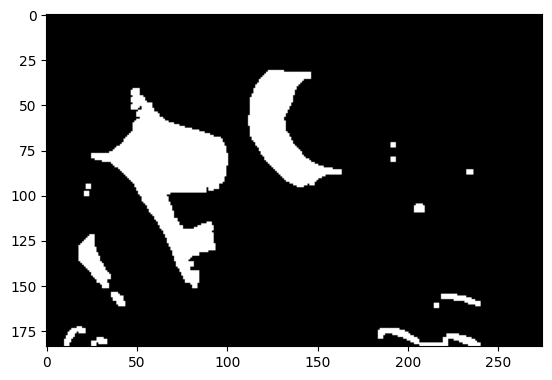

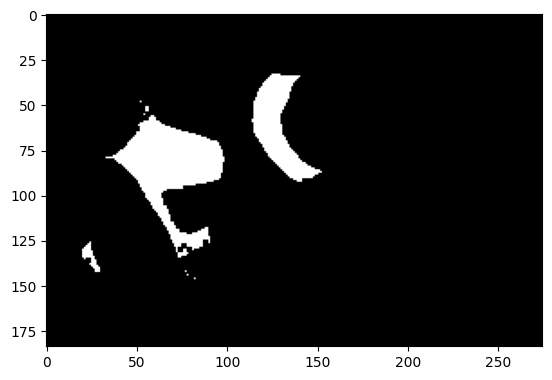

In [27]:
image_file=cv2.imread("./images/0.jpg")
print(image_file.shape)
image_file=image_file[:,:,0]
#image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2GRAY)

th, image_file = cv2.threshold(image_file, 128, 192, cv2.THRESH_OTSU)
kernel=np.ones((3,3),np.uint8)
image_dilation = cv2.dilate(image_file,kernel,iterations=1)
plt.imshow(image_dilation,cmap='gray')
plt.show()

image_erosion=cv2.erode(image_file,kernel,cv2.BORDER_REFLECT)
plt.imshow(image_erosion,cmap='gray')
plt.show()
